<h1 style="color: navy bleu;text-align:center"> Rendu du Tp7 sur Latent Variable Model

<h3 style="color: navy bleu"> Saïda Guezoui, groupe DS</h3>
<h3 style="color: navy bleu"> Julien Antigny, groupe IAAA </h3>

<h3> Importation des différentes bibliothèques et modules </h3>

In [1]:
# Lien des données et de la bibliotèque ptm
import sys
sys.path.append("Colab")

import pickle
import logging

import time
import math
import random

import numpy as np

# Affichage graphique
import matplotlib
import matplotlib.pyplot as plt

# Encoder les données
from tfidf_transform import tf_idf_transform

# Méthode K-means
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Module pour afficher les sacs de mots
from wordcloud import WordCloud

# Modèles LDA et AuthorTopicModel
from ptm.lda_gibbs import GibbsLDA
from ptm.at_model import AuthorTopicModel
from ptm.utils import convert_cnt_to_list, get_top_words

<h2>I. Chargement des données</h2>

<p>Dans cette partie, nous allons charger les données qui seront utilisées lors de ce tp. Les données initiales sont réparties dans les 5 variables suivantes :
<ul>
    <li><b>voca</b> - Liste des mots du vocabulaire de l'ensemble des documents. Les autres structures de données font référence aux indices des mots dans cette liste.</li>
    <li><b>author_name</b> - Liste des auteurs de l'ensemble des documents. Les autres structures de données font référence aux indices des auteurs dans cette liste. </li>
    <li><b>doc_author</b> - Liste de listes (une par document). La liste d'un document contient les indices des auteurs du document.</li>
    <li><b>doc_ids</b> - Liste de listes (une par document). La liste d'un document contient les indices des mots apparaissant dans le document.</li>
    <li><b>doc_cnt</b> - Liste de listes (une par document). La liste d'un document contient le nombre de fois qu'apparait chaque mot du document tel que spédicifié dans la liste correspondante dans doc_ids.</li>
</ul></p>

<p>Le code ci-dessous charge les données.</p>

In [2]:
path = "Colab/cora/"

doc_ids     = pickle.load(open(path + 'doc_ids.pkl',            'rb'))
doc_cnt     = pickle.load(open(path + 'doc_cnt.pkl',            'rb'))
doc_author  = pickle.load(open(path + 'doc_authorid.pkl',       'rb'))
author_name = pickle.load(open(path + 'authorid_authorname.pkl','rb'))
voca        = pickle.load(open(path + 'voca.pkl',               'rb'))

# Affichage d'informations sur les données
print(
f"""
Taille de docs_ids    : {len(doc_ids)},
Taille de docs_cnt    : {len(doc_cnt)},
Taille de doc_author  : {len(doc_author)},
Taille de author_name : {len(author_name)}
Taille du vocabulaire : {len(voca)},
1ere liste  docs_ids   : {doc_ids[1]},\n
1ere liste doc_cnt     : {doc_cnt[1]}
""")


Taille de docs_ids    : 13147,
Taille de docs_cnt    : 13147,
Taille de doc_author  : 13147,
Taille de author_name : 24486
Taille du vocabulaire : 17059,
1ere liste  docs_ids   : [13910, 4518, 10249, 16914, 4627, 15383, 15903, 8736, 10786, 14970, 551, 7720, 2613, 1033, 15419, 5692, 3645, 10816, 14913, 10819, 16452, 12872, 14412, 16982, 2135, 5307, 13414, 9845, 17014, 5753, 7290, 4226, 7815, 7826, 10388, 13978, 11419, 9887, 8870, 1710, 2226, 6329, 2235, 10432, 14542, 6362, 16091, 16092, 6778, 9467, 5379, 9990, 3335, 16137, 7441, 3352, 16666, 15132, 7453, 11553, 14630, 647, 2348, 15166, 15684, 8518, 14667, 11622, 3434, 1389, 16756, 13689, 2440, 13713, 12189, 9638, 13234, 6072, 7839, 15811, 7625, 13771, 2519, 4058, 10715, 4579, 4069, 7167],

1ere liste doc_cnt     : [1, 1, 1, 1, 2, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 4, 1, 1, 3, 1, 1, 3, 3, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 2, 3, 1, 2, 1, 4, 1, 3, 1, 2, 1, 1, 3, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 1, 9, 1, 1, 1, 1, 1, 1, 1, 3,

<h2>Traitement des données</h2>

Une fois que les données sont chargées, nous allons les traiter pour pouvoir les utiliser dans l'apprentissage de nos différents modèles.

<h3>A. Création de l'ensemble <i>corpus</i></h3>

<p>Pour les modèles LDA et AuthorsTopic, nous allons utiliser la liste corpus qui est une liste de listes. Chaque liste contient l'identifiant des mots qui sont présents dans le document correspondant. En d'autres termes, nous sauvegardons dans cette variables l'ensemble des mots pour chaque document.</p>

<p>Le code ci-dessous utilise la fonction <i>convert_cnt_to_list</i> pour créer notre variable.</p>

In [3]:
# Création du corpus
corpus = convert_cnt_to_list(doc_ids, doc_cnt)

# Récupération d'informations nécessaires pour la suite
n_doc    = len(corpus)
n_author = len(author_name)
n_voca   = len(voca)

<h3>B. Création de l'ensemble <i>data</i></h3>

<p> Nous allons créer une autre variable qui cette fois-ci va être structurer de la manière suivante : nous aurons une matrice de taille $n \times m$ avec $n$ le nombre de mots dans notre vocabulaire et $m$ le nombre de documents dans notre corpus ; la valeur à l'emplacement $i,j$ représente alors l'occurence du mot $i$ dans le document $j$.

In [8]:
data = tf_idf_transform(corpus, doc_ids, n_doc, n_voca)

1.6795103549957275
2.1283090114593506


<b>Distribution de fréquence du nombre de mots dans les documents</b>

Quand on travaille avec un grand nombre de documents, on peut s'intéresser dans un premier temps à connaître la taille des documents dans leur ensemble et par sujet. Traçons donc la distribution du nombre de mots pour chaque document.

In [4]:
def distribution_document_word_count(corpus):
    document_word_count = []
    
    # On récupère la taille des documents
    for doc in corpus:
        document_word_count.append(len(doc))
        
    # On trace l'histogramme
    print(f"Taille minimum : {min(document_word_count)}\nTaille maximum : {max(document_word_count)}")
    print(f"Moyenne : {np.mean(document_word_count)}")
    print(f"Mediane : {np.median(document_word_count)}")
    
    plt.figure(figsize = (20,5))
    plt.hist(document_word_count, range = (min(document_word_count), max(document_word_count)), bins = 150)
    plt.show()

Taille minimum : 20
Taille maximum : 458
Moyenne : 81.013919525367
Mediane : 75.0


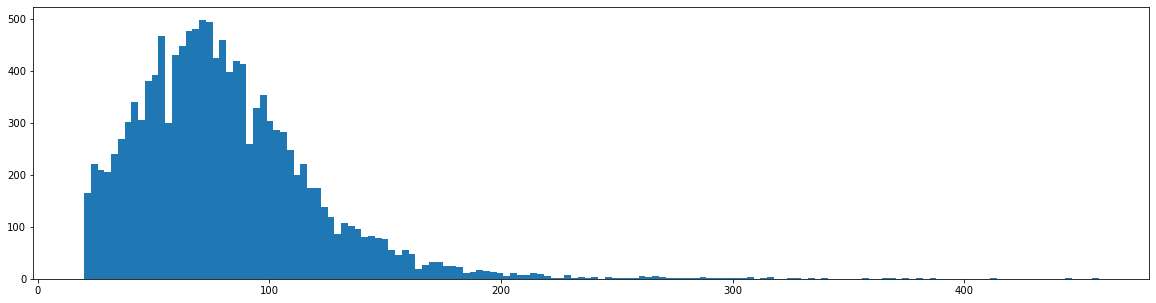

In [5]:
distribution_document_word_count(corpus)

La médiane est égale à 75 : la grande majorité des documents ont une taille comprise entre 20 et 150 mots. On remarque également qu'il y a un nombre faible de documents contenant plus de 200 mots. 

<h2>II. Utilisation de la méthode Kmeans</h2>

Nous allons commencer l'étude de nos modèles par Kmeans. D'abord nous implémentons deux fonctions qui nous seront utiles tout au long de notre étude : une première qui nous renvoie un mot à partir de son identifiant et une seconde qui nous renvoie son indice à partir du mot en question.

In [6]:
def get_word(indice, voca):
    return voca[indice]

def get_indice(word, voca):
    return voca.index(word)

Une fois cela fait, on entraine notre modèle Kmean avec les données de data.

In [9]:
K = 10
kmeans = KMeans(n_clusters = K).fit(data.T)

<p>Nous allons afficher les résultats sous forme de sac de mots à l'aide du module <i>WordCloud</i>.

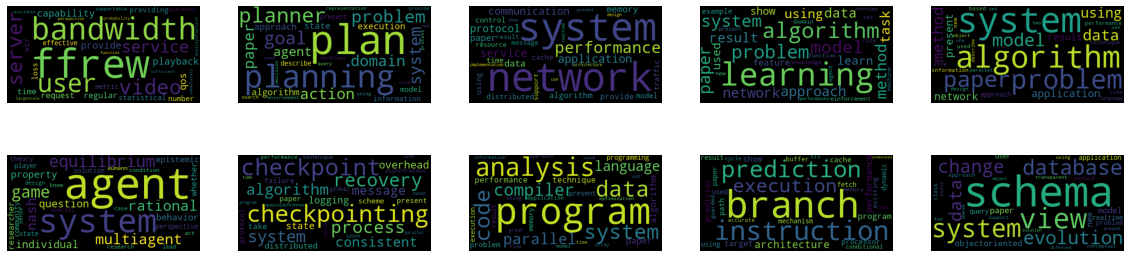

In [11]:
N = len(corpus)

plt.figure(figsize = (20,5))
for k in range(K):
    # On récupère les mots avec leur occurence dans l'ensemble des documents du topic
    text = []
    for n in range(N):
        if kmeans.labels_[n] == k:
            for index in corpus[n]:
                text.append(f"{get_word(index,voca)}")
    
    # On mélange notre liste pour éviter des bugs d'affichage
    random.shuffle(text)
    text = " ".join(text)
    
    # Création du sac de mots
    wordcloud = WordCloud(background_color = 'black', max_words = 30).generate(text)
    
    # Affichage
    plt.subplot(2,5, k+1)
    plt.imshow(wordcloud)
    plt.axis("off")
    
plt.show()

<p>On trouve des topics qui sont différents. On peut néanmoins noter qu'on retrouve des mots qui reviennent souvent comme "algorithm", "system".</p>
<p>On peut s'intéresser à l'effet du nombre de cluesters dans l'apprentissage en calculant la somme des distances au carré</p>

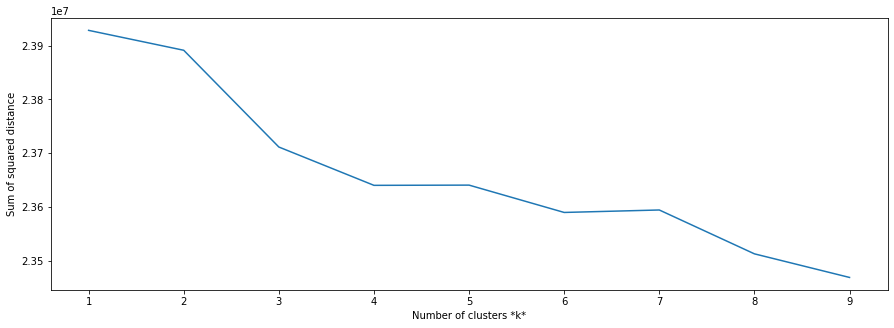

In [10]:
sse = []
K = list(range(1, 10))

for k in K:
    km = KMeans(n_clusters = k)
    km.fit(data)
    sse.append(km.inertia_)
    
plt.figure(figsize=(15, 5))
plt.plot(K, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.title("Evolution de sse en fonction de k ")
plt.show()

Le résultat montre une certaine decroissance de la somme des carrées des distances lorsque on augmente le nombre de clusters. Autrement dit, plus on a de topics, plus on aura tendance à avoir des sujets proches. 

<h2>III. Utilisation du modèle LDA</h2>

Une autre façon d'apprendre des topics est d'utiliser le modèle LDA. On utilise la bibliothèque ptm pour entraîner notre modèle. Cette fois-ci, on utilise l'ensemble corpus comme jeu de données.

In [11]:
max_iter =  3
n_topic  = 3

modelLDA = GibbsLDA(n_doc, len(voca), n_topic)
modelLDA.fit(corpus, max_iter = max_iter)

2021-12-16 13:21:48 INFO:GibbsLDA:[ITER] 0,	elapsed time:16.13,	log_likelihood:-9564292.78
2021-12-16 13:22:05 INFO:GibbsLDA:[ITER] 1,	elapsed time:17.21,	log_likelihood:-9467507.44
2021-12-16 13:22:23 INFO:GibbsLDA:[ITER] 2,	elapsed time:17.43,	log_likelihood:-9388553.51


On affiche de nouveau les sacs de mots correspondant aux différents topics

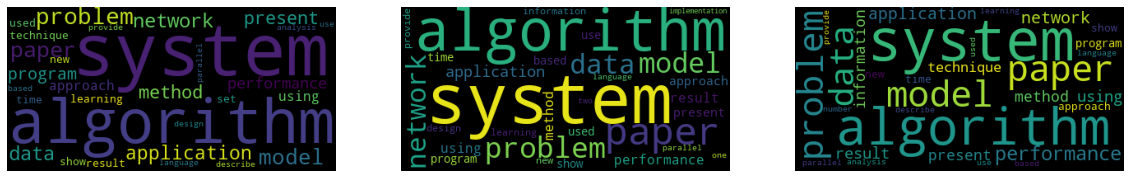

In [12]:
plt.figure(figsize = (20,5))
for k in range(3):
    text = []
    for i in range(len(modelLDA.topic_assignment)):
        for j in range(len(modelLDA.topic_assignment[i])):
            if modelLDA.topic_assignment[i][j] == k:
                text.append(get_word(corpus[i][j], voca))

    random.shuffle(text)

    text = (" ").join(text)
    
    plt.subplot(1,3,k+1)
    wordcloud = WordCloud(background_color = 'black', max_words = 30).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
plt.show()

Avec ce le model LDA, On observe qu'il n'y a pas une différence significative entre les 3 topics. On retrouve toujours les mots "system" et "algorithm" qui sont les plus importantes. Une légère différence avec l'algorithme de Kmeans, essayons donc d'augmenter le nombre de topics.

In [16]:
max_iter =  3
n_topic  = 10

modelLDA = GibbsLDA(n_doc, len(voca), n_topic)
modelLDA.fit(corpus, max_iter = max_iter)

2021-12-17 23:07:19 INFO:GibbsLDA:[ITER] 0,	elapsed time:16.52,	log_likelihood:-10866573.47
2021-12-17 23:07:35 INFO:GibbsLDA:[ITER] 1,	elapsed time:15.26,	log_likelihood:-10531440.86
2021-12-17 23:07:51 INFO:GibbsLDA:[ITER] 2,	elapsed time:16.52,	log_likelihood:-10283303.13


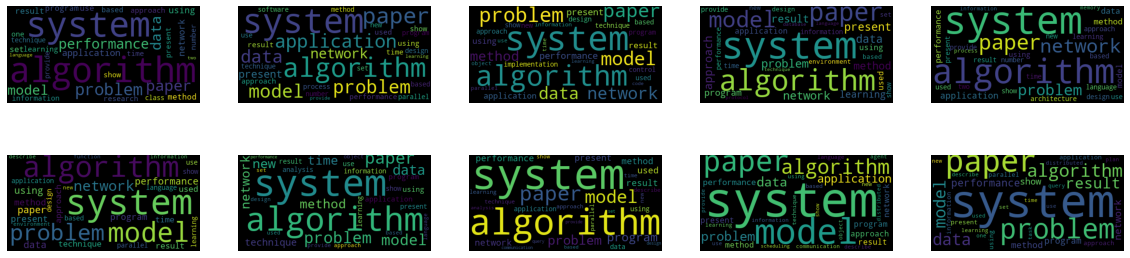

In [17]:
plt.figure(figsize = (20,5))
for k in range(10):
    text = []
    for i in range(len(modelLDA.topic_assignment)):
        for j in range(len(modelLDA.topic_assignment[i])):
            if modelLDA.topic_assignment[i][j] == k:
                text.append(get_word(corpus[i][j], voca))

    random.shuffle(text)

    text = (" ").join(text)
    
    plt.subplot(2, 5, k + 1)
    wordcloud = WordCloud(background_color = 'black', max_words = 30).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
plt.show()

Le résultat est assez similaire avec le cas où le nombre de topics est égal à 3 où on retrouve également "algorithm" et "system" dans tous les 10 topics. Encore une fois, la différence se base principalement sur les thématiques secondaires.
On peut conclure qu'il y a plus de différence entre les topics avec le modèle des Kmeans et que l'ensemble des topics font partie d'une thématique générale d'après le modèle LDA : celle de l'informatique.

<h2>IV. Utilisation du modèle Author Topic</h2>

<p>On utilise un dernier modèle : Author topic. Pareil pour les modèles précédents, on entraine notre modèle et on affiche les sacs de mots qui sont associés aux topics appris.</p>

In [12]:
max_iter = 3
n_topic  = 10

modelAT = AuthorTopicModel(n_doc, n_voca, n_topic, n_author)

modelAT.fit(corpus, doc_author, max_iter = max_iter)

2021-12-17 23:01:03 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:59.03	log_likelihood:-10863470.06
2021-12-17 23:02:07 INFO:AuthorTopicModel:[INIT] 1	elapsed_time:63.78	log_likelihood:-10644886.59
2021-12-17 23:03:11 INFO:AuthorTopicModel:[INIT] 2	elapsed_time:63.52	log_likelihood:-10487300.25


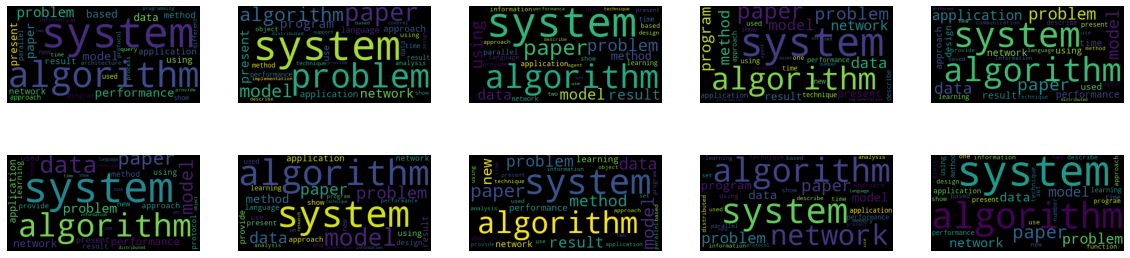

In [13]:
plt.figure(figsize = (20,5))
for k in range(10):
    text = []
    for i in range(len(modelAT.topic_assigned)):
        for j in range(len(modelAT.topic_assigned[i])):
            if modelAT.topic_assigned[i][j] == k:
                text.append(get_word(corpus[i][j], voca))

    random.shuffle(text)

    text = (" ").join(text)
    
    plt.subplot(2, 5, k + 1)
    wordcloud = WordCloud(background_color = 'black', max_words = 30).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
plt.show()

<p>Là encore, on ne voit de différence entre les topics sur les mots les plus importants. Néanmoins, les différences peuvent se trouver dans les mots plus spécifiques. Pour voir la différence entre les topics, on va calculer la similarité entre ces derniers.</p>

<p>Pour finir cette partie, on peut comparer la distribution de la taille des documents selon leur appartenance à un topic. Pour ce faire, on implémente une fonction qui nous renvoie l'appartenance la plus probable d'un document.

In [14]:
def get_topics(doc):
    """ Renvoie la liste du nombre de mots appartenant à un topic pour un document """
    topic_set = np.arange(0,max(doc)+1)
    count_topic = [0] * len(topic_set)
    
    for topic in doc:
        count_topic[topic] += 1
        
    return count_topic

def in_topic(doc):
    """ Renvoie le topic le plus probable d'un document """
    index_max = -1
    maximum = -1
    
    count_topic = get_topics(doc)
    
    for i in range(len(count_topic)):
        if count_topic[i] > maximum:
            maximum = count_topic[i]
            index_max = i
            
    return index_max, maximum

Puis on observe la distribution selon les topics.

<b>Modèle LDA</b>

Taille minimum : 20
Taille maximum : 387
Moyenne : 81.7180774748924
Mediane : 74.5


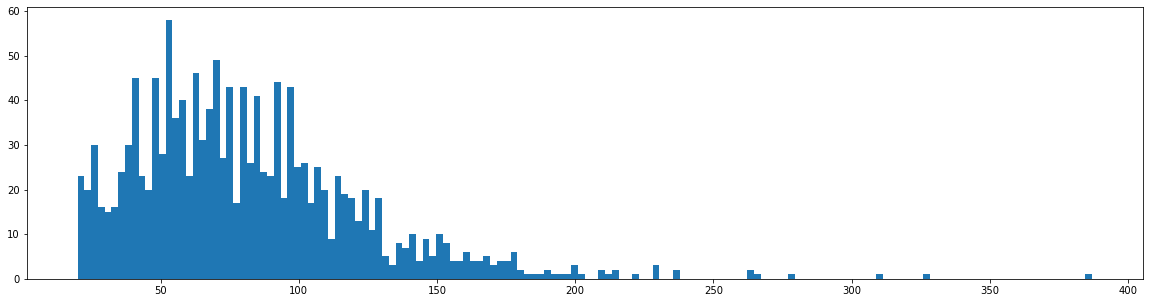

Taille minimum : 20
Taille maximum : 414
Moyenne : 82.03946388682056
Mediane : 75.0


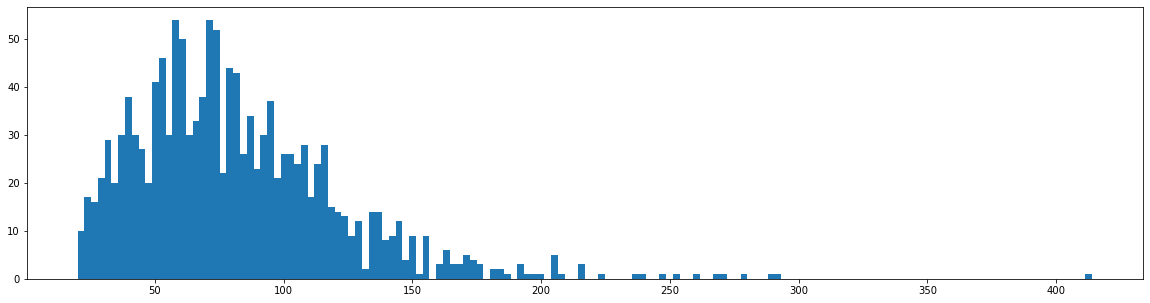

Taille minimum : 20
Taille maximum : 299
Moyenne : 81.10515021459227
Mediane : 75.0


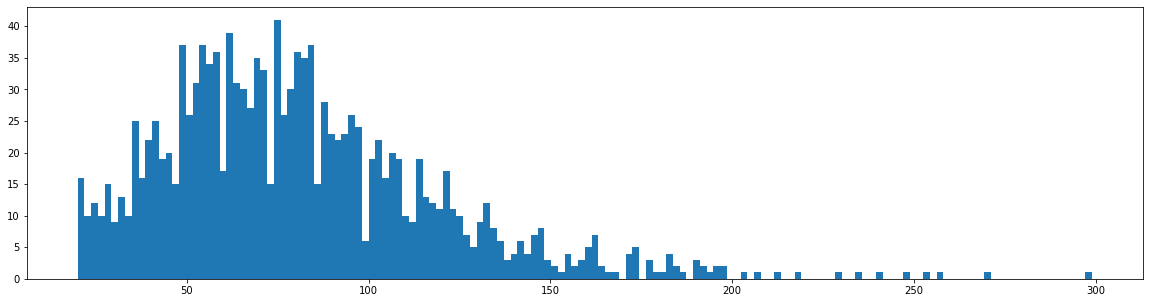

Taille minimum : 20
Taille maximum : 380
Moyenne : 79.57344632768361
Mediane : 73.0


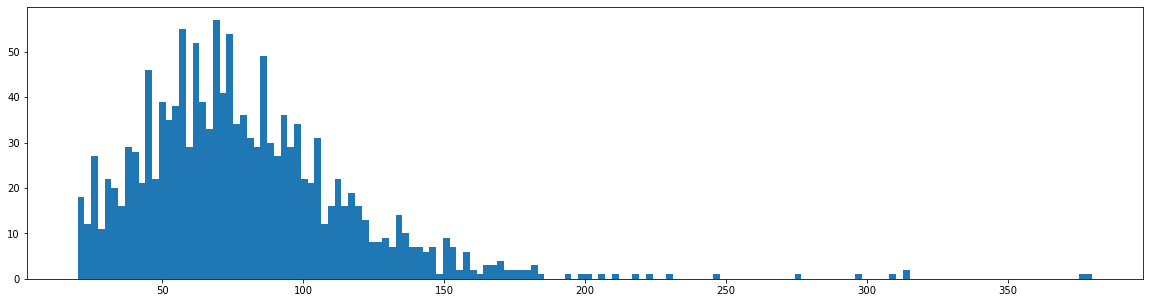

Taille minimum : 20
Taille maximum : 324
Moyenne : 82.43668457405987
Mediane : 78.0


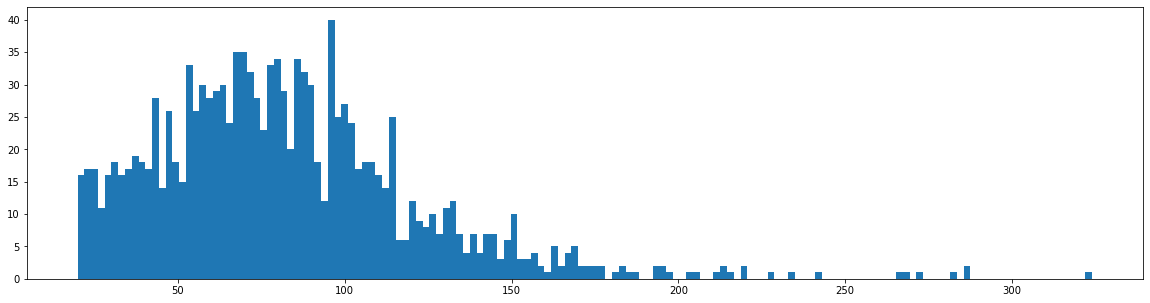

Taille minimum : 20
Taille maximum : 369
Moyenne : 80.33026113671275
Mediane : 76.0


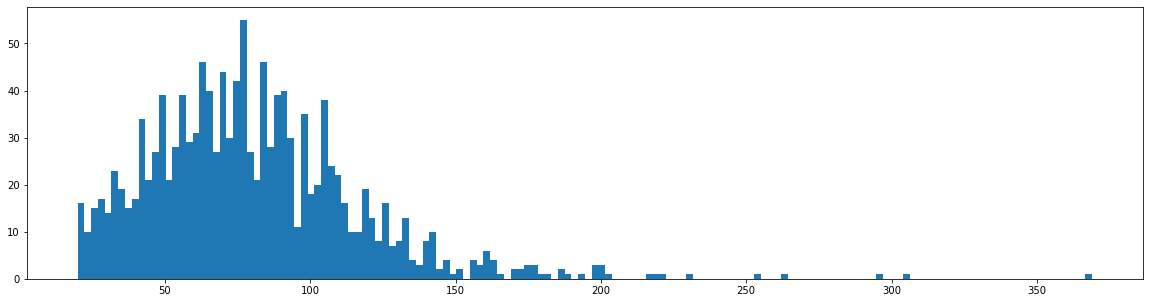

Taille minimum : 20
Taille maximum : 412
Moyenne : 79.69991823385118
Mediane : 74.0


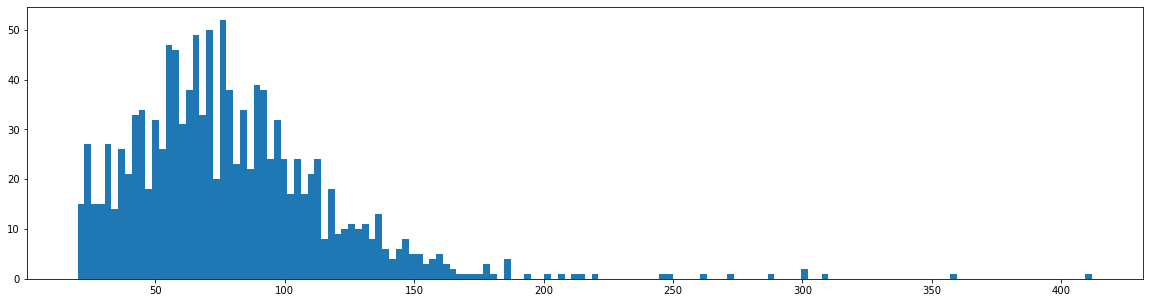

Taille minimum : 20
Taille maximum : 458
Moyenne : 80.22940226171244
Mediane : 74.5


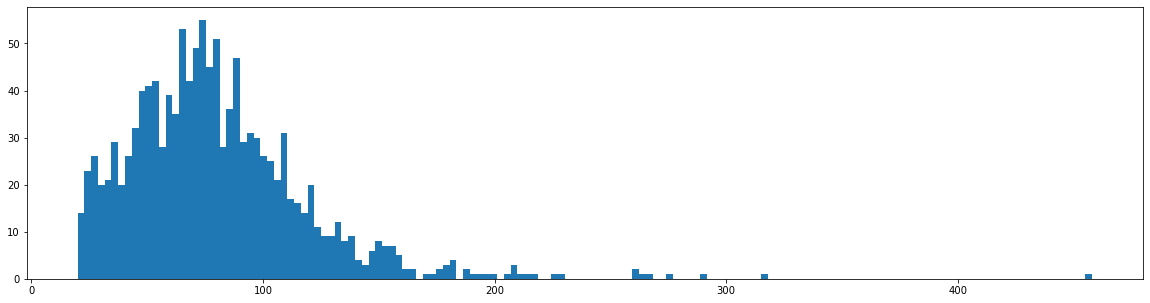

Taille minimum : 20
Taille maximum : 444
Moyenne : 81.26204819277109
Mediane : 75.5


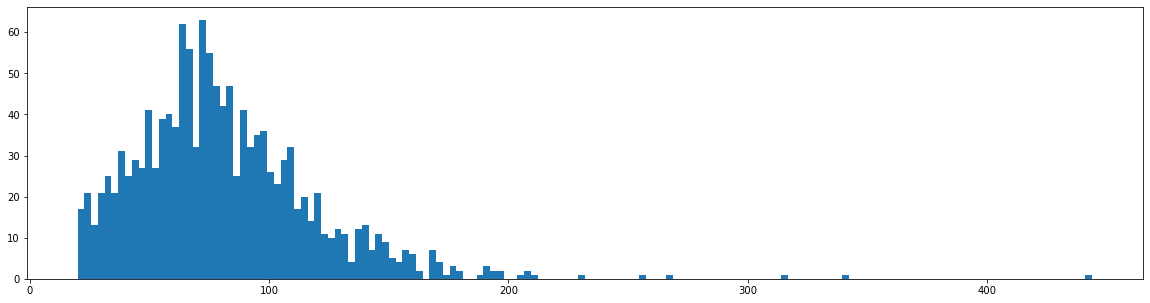

Taille minimum : 20
Taille maximum : 367
Moyenne : 81.71131447587355
Mediane : 77.5


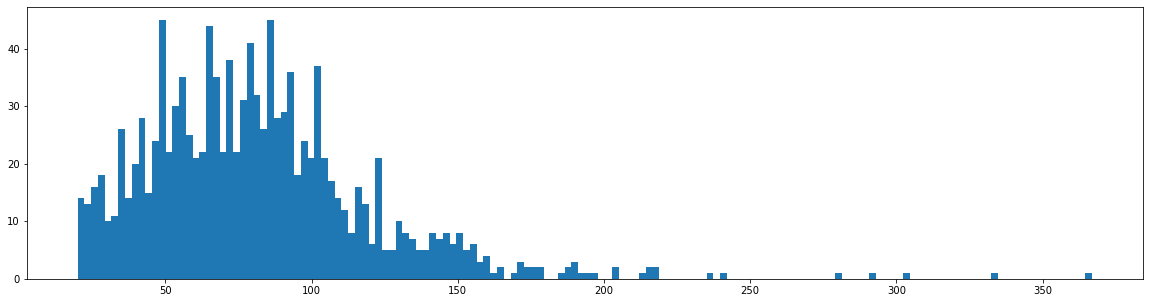

In [18]:
for k in range(0,10):
    corpus_topic = []
    for i in range(len(corpus)):
        if in_topic(modelLDA.topic_assignment[i])[0] == k:
            corpus_topic.append(corpus[i])
        
    distribution_document_word_count(corpus_topic)

<p>On n'observe pas de différence entre les topics : les distributions des topics ont la même allure que celle pour l'ensemble des documents.</p>

<b>Modèle Kmeans</b>

Taille minimum : 137
Taille maximum : 137
Moyenne : 137.0
Mediane : 137.0


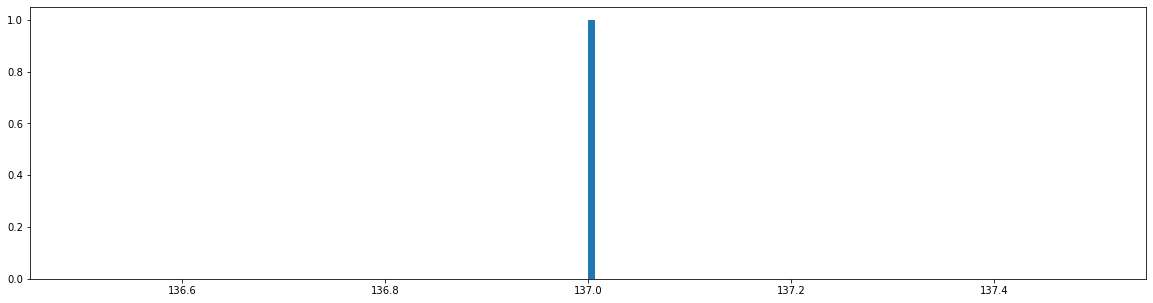

Taille minimum : 20
Taille maximum : 333
Moyenne : 105.70212765957447
Mediane : 97.0


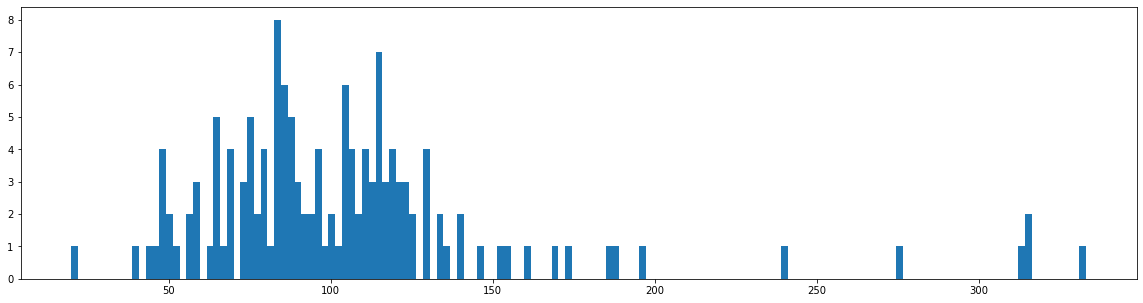

Taille minimum : 30
Taille maximum : 458
Moyenne : 112.64692653673164
Mediane : 104.0


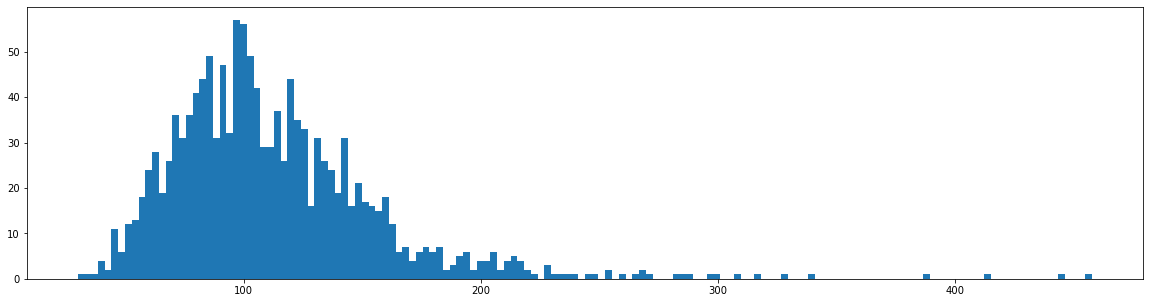

Taille minimum : 25
Taille maximum : 380
Moyenne : 94.28
Mediane : 87.0


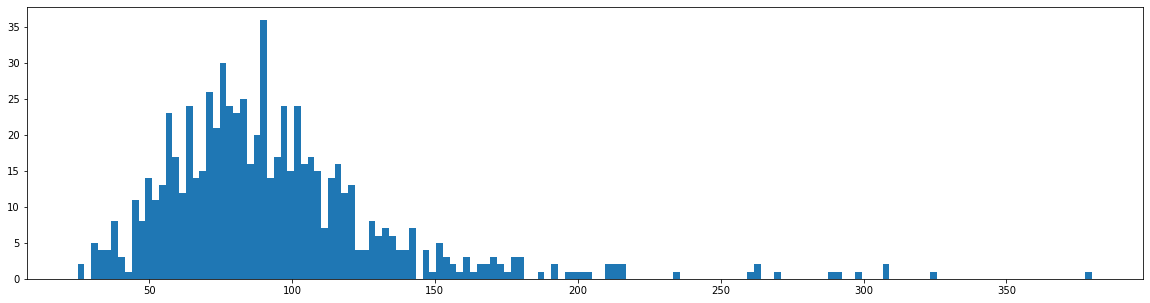

Taille minimum : 20
Taille maximum : 358
Moyenne : 73.73856470823742
Mediane : 69.0


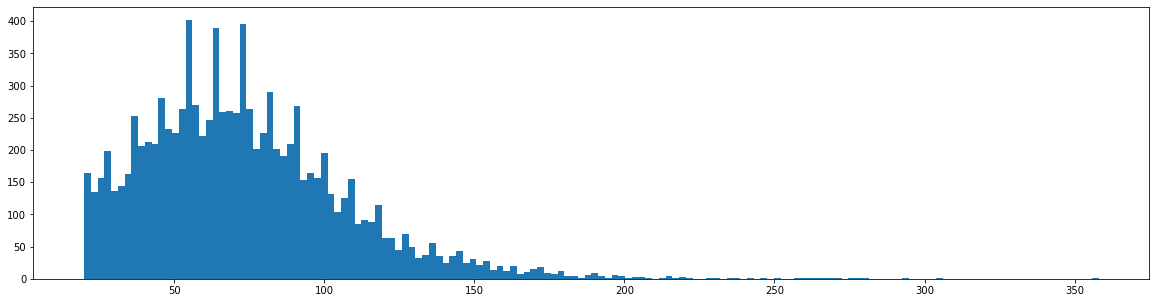

Taille minimum : 367
Taille maximum : 367
Moyenne : 367.0
Mediane : 367.0


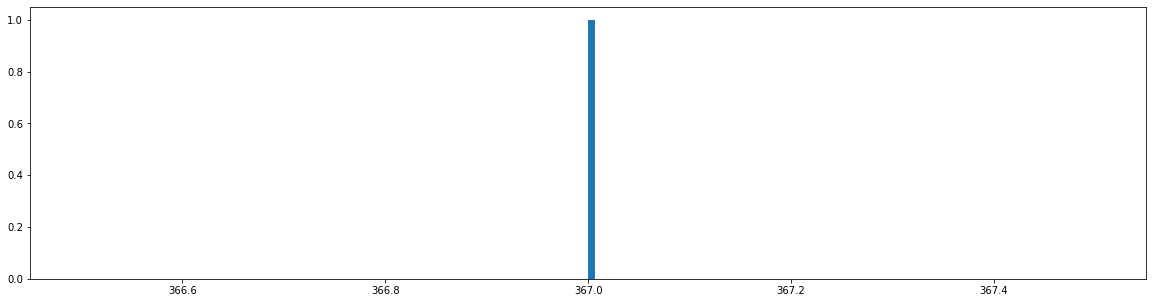

Taille minimum : 67
Taille maximum : 162
Moyenne : 105.6875
Mediane : 110.0


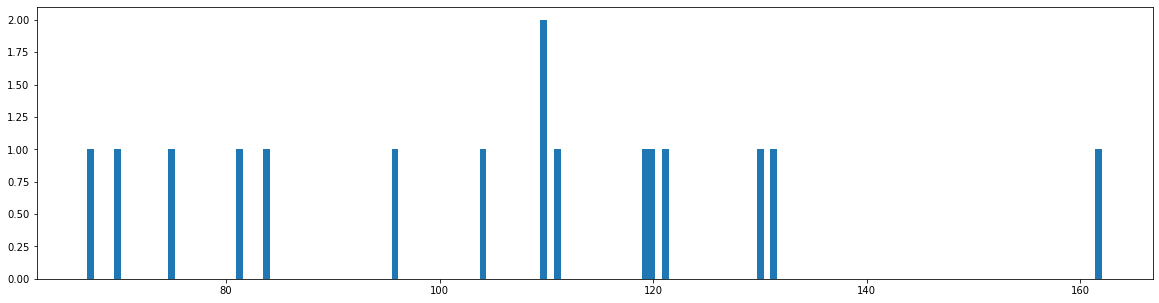

Taille minimum : 28
Taille maximum : 412
Moyenne : 98.10572687224669
Mediane : 90.0


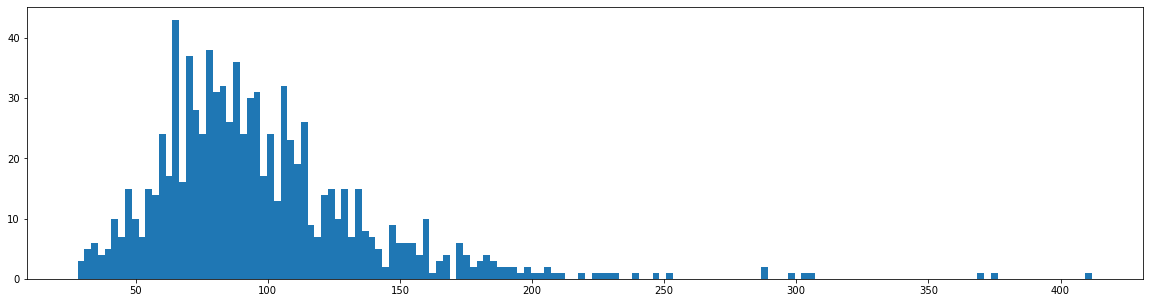

Taille minimum : 82
Taille maximum : 164
Moyenne : 125.75
Mediane : 131.5


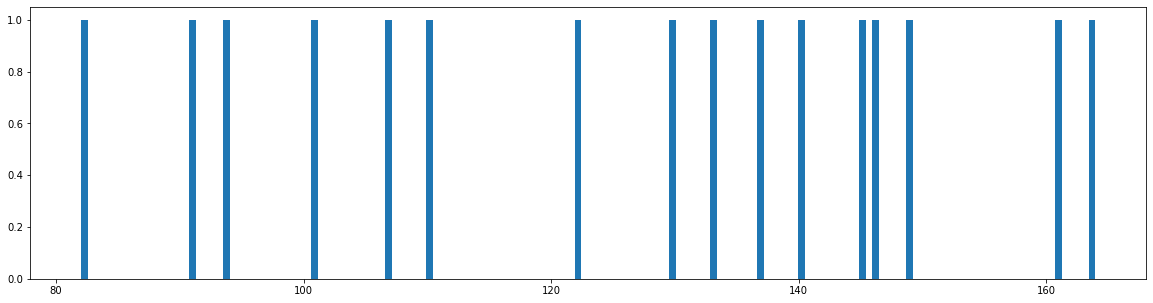

Taille minimum : 45
Taille maximum : 171
Moyenne : 110.92857142857143
Mediane : 106.0


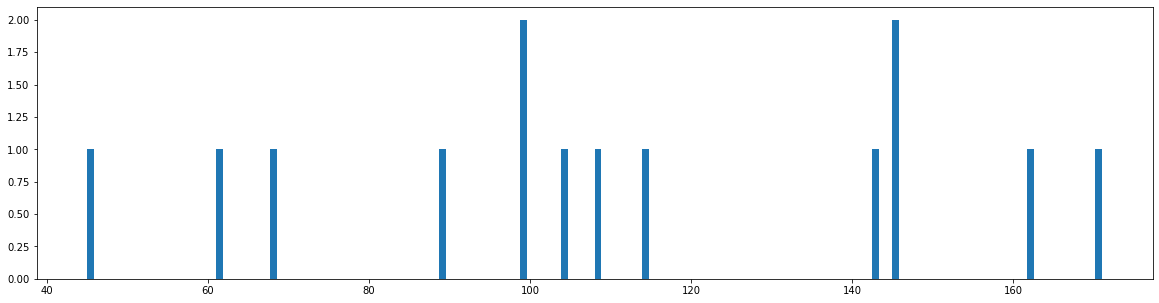

In [22]:
for k in range(0,10):
    corpus_topic = []
    for i in range(len(corpus)):
        if kmeans.labels_[i] == k:
            corpus_topic.append(corpus[i])
        
    distribution_document_word_count(corpus_topic)

<p>On remarque qu'il y des fortes différences entre les topics. Certains topics contiennent très peu de documents (1 seul pour le topic 0 et 16 pour le topic 7). Mais si le nombre de documents est important, alors on retrouve la même distribution que précédement.</p>

<h2>V. Similarité entre les topics</h2>

<p>Dans cette partie, on va calculer la similarité entre les différents topics appris. Pour cela, nous allons utiliser la fonction <i>cosine_similarity</i> du module <i>metrics</i> de Sklearn.</p>

<h3>A. Définition de la similarité</h3>

In [16]:
similarity_matrix = cosine_similarity(data.T)
similarity_matrix = np.round(similarity_matrix,5)

print(similarity_matrix)

[[1.000e+00 7.561e-02 2.000e-05 ... 4.570e-03 2.414e-02 7.500e-04]
 [7.561e-02 1.000e+00 6.970e-03 ... 1.939e-02 1.476e-02 5.000e-05]
 [2.000e-05 6.970e-03 1.000e+00 ... 1.770e-03 6.000e-05 8.000e-04]
 ...
 [4.570e-03 1.939e-02 1.770e-03 ... 1.000e+00 4.540e-03 2.131e-02]
 [2.414e-02 1.476e-02 6.000e-05 ... 4.540e-03 1.000e+00 4.700e-04]
 [7.500e-04 5.000e-05 8.000e-04 ... 2.131e-02 4.700e-04 1.000e+00]]


<p>Cette matrice contient les valeurs de similarité entre les différents documents. La valeur de la similarité cosinus est donnée par la formule suivante :
$$ K(X, Y) = \frac{<X, Y>}{||X|| \cdot ||Y||} $$
On observe que la diagonale de la matrice est égale à 1 : c'est normal car un document est forcément exactement similaire avec lui même. La matrice est symétrique car la similarité par cosinus est elle même symétrique.</p>
<p>Pour déterminer la similarité entre deux topics, nous allons procéder de la manière suivante :
   <ol>
       <li>On sélectionne les documents qui appartiennent à l'un des deux topics à comparé.</li>
       <li>On construit deux matrices (un pour chaque topic) contient les lignes de la matrice data des documents appartenant au topic.</li>
       <li>On applique la fonction de similaratié cosinus sur les deux matrices créées.</li>
   </ol> 
Pour ce faire, nous allons implémenter la fonction <b>compute_similarity</b> qui prend en paramètre notre data, les topics labels appris et les deux topics à comparer.


In [17]:
def compute_similarity(data, topic_assignment, topic_1, topic_2, mode = ""):
    """
    Calcul du max, min ou moyenne de similarité entre deux topics
    
    Paramètres
    ----------
    data : (nombre de documents, nombre de mots dans le vocabulaire)
    topic_assignment : 
    topic_1 : 
    topic_2 : 
    mode :
    
    Sortie
    ------
    Renvoie la valeur du max, du min ou de la moyenne selon le choix
    """
    
    # On copie notre data
    data_tpm = data.copy()
    
    # On filtre notre data selon l'appartenance des topic_1 et topic_2
    indice_topic = [[],[]]
    for i in range(data.shape[0]):
        if in_topic(topic_assignment[i])[0] == topic_1:
            indice_topic[0].append(i)
        elif in_topic(topic_assignment[i])[0] == topic_2:
            indice_topic[1].append(i)
        else:
            pass
        
    # On construit nos deux matrices
    data_topic_1 = data[indice_topic[0]]
    data_topic_2 = data[indice_topic[1]]
    
    # On calcule la similarité entre les deux matrices
    similarity_matrix = cosine_similarity(data_topic_1, data_topic_2)
        
    if   mode == "max"  : return np.max(similarity_matrix)
    elif mode == "min"  : return np.min(similarity_matrix)
    elif mode == "mean" : return np.mean(similarity_matrix)
    elif mode == "mmm"  : return (np.max(similarity_matrix), np.min(similarity_matrix), np.mean(similarity_matrix))
    else : return similarity_matrix

<p>Par exemple, on peut calculer la similarité entre le topic 1 et 2 pour le modèle LDA.</p>

In [31]:
print(compute_similarity(data.T, modelLDA.topic_assignment, 1, 2, mode = "mmm"))

(0.9800385691373628, 0.0, 0.01390256921759259)


La première valeur du vecteur correspond à la similarité maximale qui est de 98% entre les documents, la deuxième au minimum de la similarité qui est nulle. Enfin, en moyenne il y a environ 1% de similarité entre ces documents. Autrement dit, entre ces deux topics, il y quelques documents ayant des sujets proches mais aussi ceux qui sont tout à fait différents. 

<h3>Similarités entre les topics en fonction du nombre d'itérations</h3>

<h4>Modèle LDA</h4>
<p>On entraine un modèle LDA avec un nombre d'itération allant de 1 à 20 avec un pas de 2, puis on calcule la similartité entre les différents topics pour observer l'impacte du nombre d'itérations. Pour que les calculs ne soient pas trop long, on se limite à 5 topics.</p>

In [89]:
# Entraînement des modèles
models_LDA = []

for i in [1,2,4,6,8,10,12,14,16,18,20]:
    modelLDA = GibbsLDA(n_doc, len(voca), 5)
    modelLDA.fit(corpus, max_iter = i)
    models_LDA.append(modelLDA)

2021-12-16 16:55:47 INFO:GibbsLDA:[ITER] 0,	elapsed time:11.00,	log_likelihood:-10127470.97
2021-12-16 16:56:01 INFO:GibbsLDA:[ITER] 0,	elapsed time:11.78,	log_likelihood:-10127583.23
2021-12-16 16:56:13 INFO:GibbsLDA:[ITER] 1,	elapsed time:11.36,	log_likelihood:-9951807.43
2021-12-16 16:56:28 INFO:GibbsLDA:[ITER] 0,	elapsed time:12.41,	log_likelihood:-10126834.79
2021-12-16 16:56:41 INFO:GibbsLDA:[ITER] 1,	elapsed time:12.87,	log_likelihood:-9952410.03
2021-12-16 16:56:53 INFO:GibbsLDA:[ITER] 2,	elapsed time:12.05,	log_likelihood:-9810677.19
2021-12-16 16:57:05 INFO:GibbsLDA:[ITER] 3,	elapsed time:11.92,	log_likelihood:-9693361.46
2021-12-16 16:57:19 INFO:GibbsLDA:[ITER] 0,	elapsed time:11.66,	log_likelihood:-10127838.19
2021-12-16 16:57:30 INFO:GibbsLDA:[ITER] 1,	elapsed time:11.72,	log_likelihood:-9950459.19
2021-12-16 16:57:42 INFO:GibbsLDA:[ITER] 2,	elapsed time:11.25,	log_likelihood:-9811684.37
2021-12-16 16:57:54 INFO:GibbsLDA:[ITER] 3,	elapsed time:12.40,	log_likelihood:-969540

<p>On affiche l'évolution de la similarité maximum, moyenne et minimum entre les topics pour chaque itération. Pour ce faire, on implémente une fonction get_similarity_list qui nous renvoie les matrices de similarité entre deux topics choisis pour les différents modèles entrainés. Puis, affiche sur un même niveau l'évolution des valeurs de similarité selon le nombre d'itérations. On fait cela entre tous les topics.</p>

In [90]:
def get_similarity_list(model_list, topic_1, topic_2):
    """ Calcul des matrices de similarité entre topic_1 et topic_2 selon différents modèles"""
    similarity_list = []
    
    for model in model_list:
        similarity_list.append(compute_similarity(data.T, model.topic_assignment, topic_1, topic_2, mode = ""))
        
    return similarity_list

def get_coef_max(matrix):
    """ Récupération du maximum sans prendre en compte la diagonale """
    maximum = -1
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if i == j:
                pass
            else:
                if matrix[i,j] > maximum:
                    maximum = matrix[i,j]
    return maximum

def compute_max_mean_min(similarity_list):
    max_list, mean_list, min_list = [], [], []
    """ Calcul du maximum, minimum et de la moyenne """
    for matrix in similarity_list:
        max_list.append(coef_max(matrix))
        mean_list.append(np.mean(matrix))
        min_list.append(np.min(matrix))
        
    return max_list, mean_list, min_list

def plot_results(max_list, mean_list, min_list):
    """ Affichage des résultats """
    plt.figure(figsize = (20, 5))

    plt.subplot(1,3,1)
    for i in range(len(max_list)):
        plt.plot(np.arange(len(max_list)), max_list)

    plt.subplot(1,3,2)
    for i in range(len(mean_list)):
        plt.plot(np.arange(len(mean_list)), mean_list)

    plt.subplot(1,3,3)
    for i in range(len(min_list)):
        plt.plot(np.arange(len(min_list)), min_list)

    plt.show()

Similarité entre topic 1 et 0
11


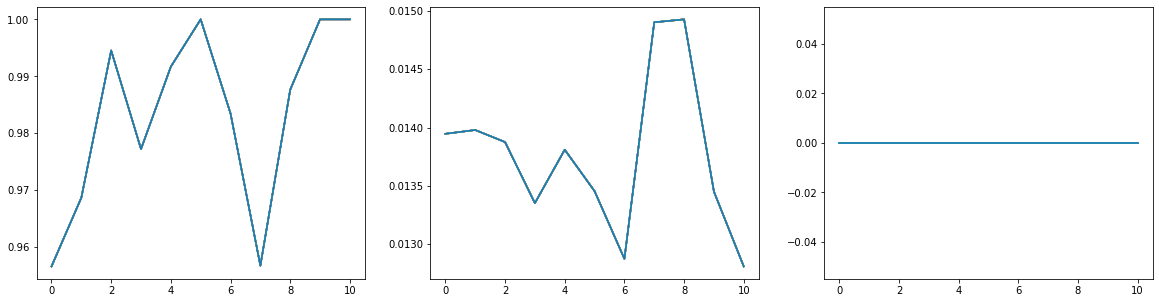

Similarité entre topic 2 et 0
11


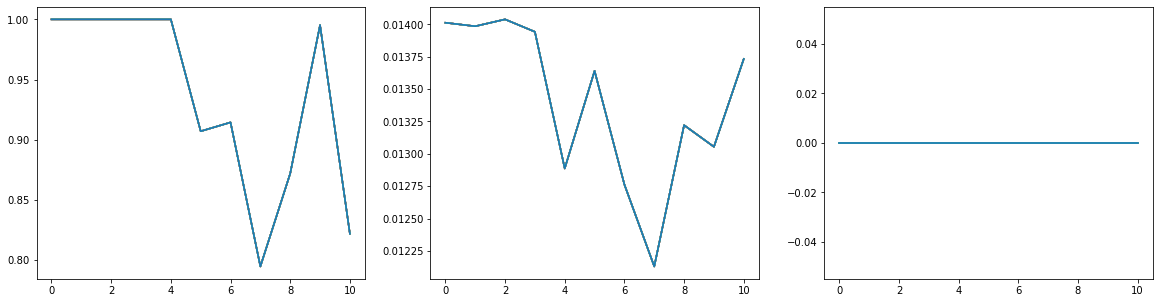

Similarité entre topic 2 et 1
11


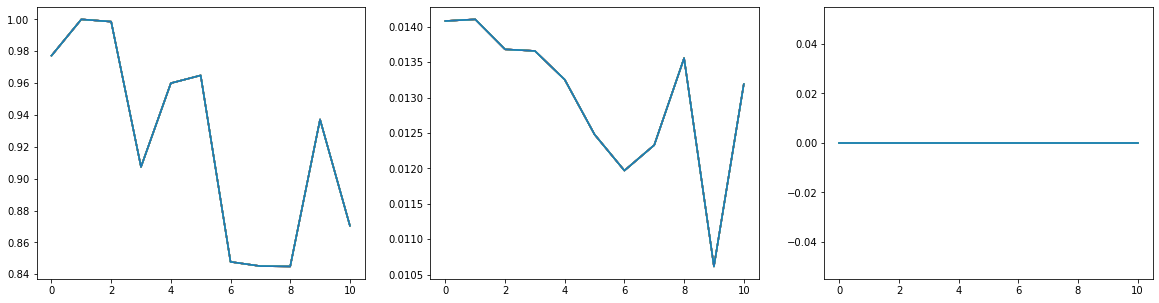

Similarité entre topic 3 et 0
11


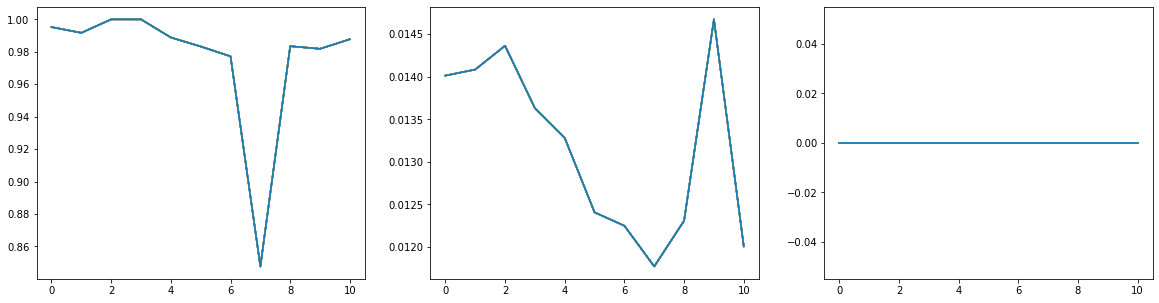

Similarité entre topic 3 et 1
11


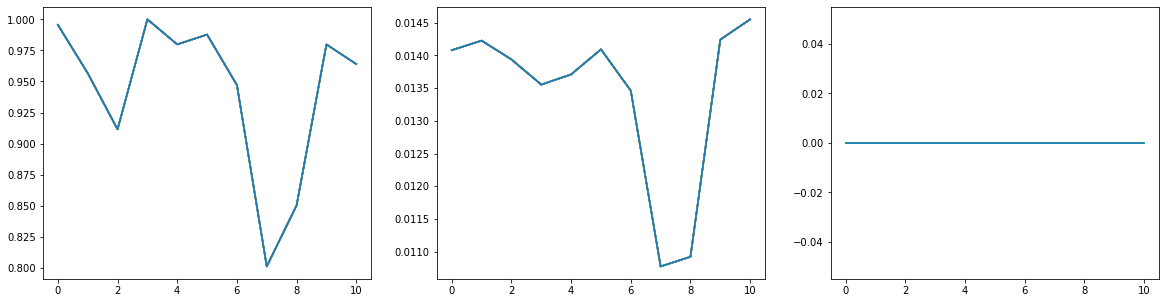

Similarité entre topic 3 et 2
11


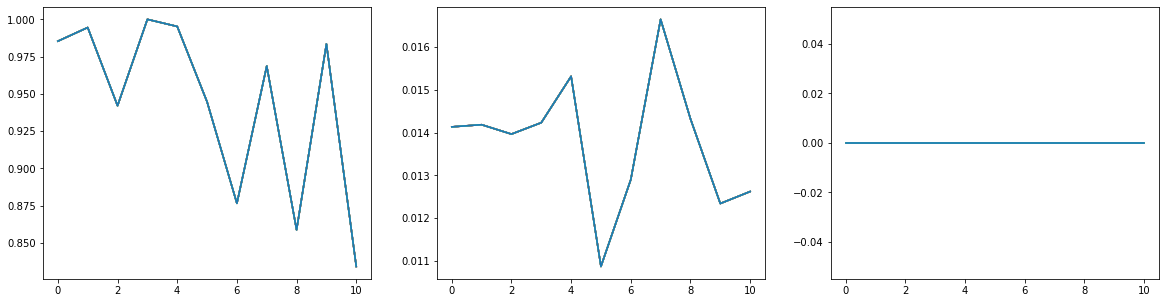

Similarité entre topic 4 et 0
11


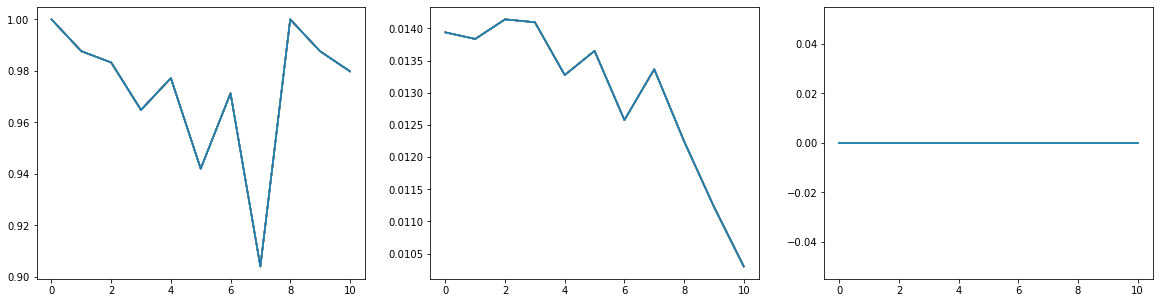

Similarité entre topic 4 et 1
11


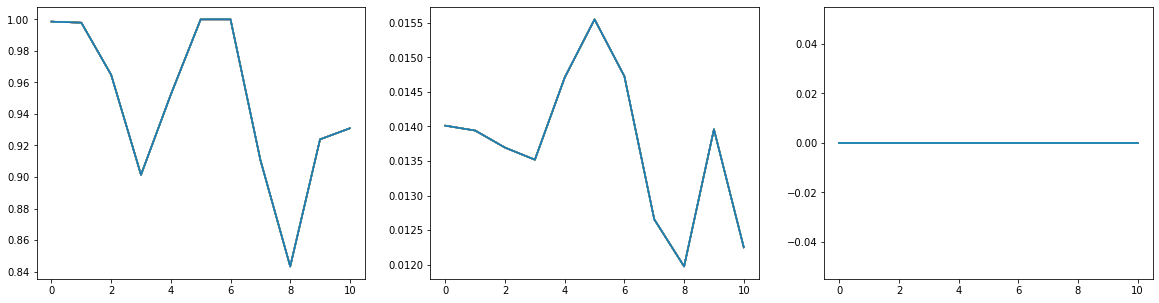

Similarité entre topic 4 et 2
11


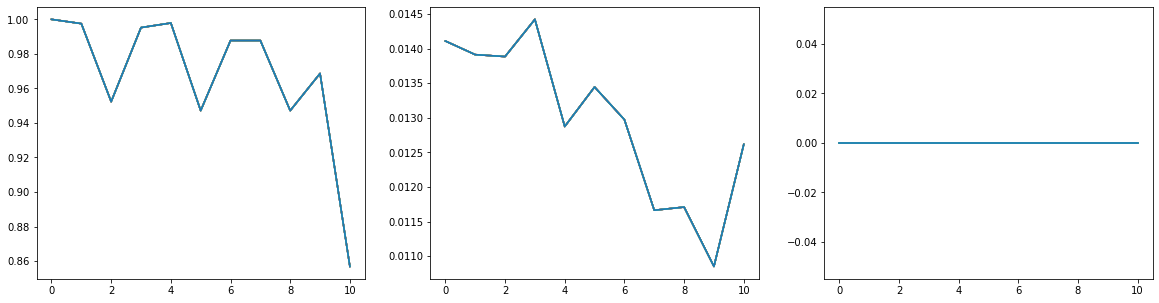

Similarité entre topic 4 et 3
11


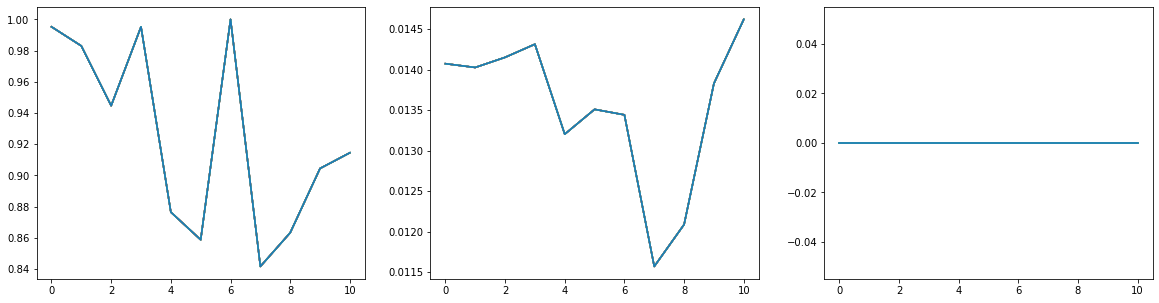

In [91]:
for i in range(5):
    for j in range(i):
        similarity_list = get_similarity_list(models_LDA, i, j)
        max_list, mean_list, min_list = compute_max_mean_min(similarity_list)
        print(f"Similarité entre topic {i} et {j}")
        plot_results(max_list, "Similarité maximale en fonction des itérations")
        plot_results(mean_list, "Similarité moyenne en fonction des itérations")
        plot_results(min_list, "Similarité minimale en fonction des itérations")

<p>Le nombre d'itérations est peut être trop faible pour pouvoir conclure à partir de nos résultats, mais on peut voir que sur certain topic la similarité moyenne a tendance à baisser.
    
Néanmoins, pour la grande majorité des comparaisons, on ne peut en déduire une tendance. Pour le cas de la similarité minimale, elle reste nulle pour toutes les itérations et les comparaisons entre topics.

Enfin, la similarité maximale varie grandement entre les différentes itérations, il est impossible de voir une tendance entre les différentes comparaisons, mais on constate qu'elle reste toujours à un niveau élevé (plus de 84% au minimum).</p>

#### Conclusion 

Dans ce tp, après avoir nettoyé et traité l'ensemble de données pour créer les différents modèles : LDA, Kmeans et Author model, nous avons pu découvrir plusieurs façons de visualiser les sorties des modèles de topics. Les modèles nous ont permis d'avoir un peu plus de détail et enfin le calcul de similarité fournissent plus de précisions sur le clustering des sujets.